In [1]:
import pandas as pd
import datetime as dt
from pandas.core.frame import DataFrame
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup
import watermark
from collections import namedtuple
from adjustText import adjust_text
from pathlib import Path

print(
    watermark.watermark(iversions=True, python=True, machine=True, globals_=globals())
)

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 8.28.0

Compiler    : GCC 15.1.1 20250705
OS          : Linux
Release     : 6.16.0-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 7940HS w/ Radeon 780M Graphics
CPU cores   : 16
Architecture: 64bit

adjustText: 1.3.0
numpy     : 2.2.6
watermark : 2.5.0
bs4       : 4.13.3
matplotlib: 3.10.5
seaborn   : 0.13.2
pandas    : 2.3.1
requests  : 2.32.3



In [2]:
import os

os.environ.pop("HTTP_PROXY", None)
os.environ.pop("HTTPS_PROXY", None)

In [3]:
!wget -O data/alldata.csv https://salsa.debian.org/benchmarksgame-team/benchmarksgame/-/raw/master/public/data/alldata.csv

--2025-08-04 15:46:06--  https://salsa.debian.org/benchmarksgame-team/benchmarksgame/-/raw/master/public/data/alldata.csv
Resolving salsa.debian.org... 209.87.16.44, 2607:f8f0:614:1::1274:44
Connecting to salsa.debian.org|209.87.16.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1292613 (1.2M) [text/plain]
Saving to: ‘data/alldata.csv’

data/alldata.csv    100%[===================>]   1.23M   252KB/s    in 5.0s    

2025-08-04 15:46:12 (252 KB/s) - ‘data/alldata.csv’ saved [1292613/1292613]



In [4]:
lang_dict = {
    # "C": "C/C++",
    # "C++": "C/C++",
    "Delphi/Object Pascal": "Delphi/Pascal",
    "MATLAB": "Matlab",
    "Cobol": "COBOL",
    # "VBA": "Visual Basic",
    "Powershell": "PowerShell",
    "VBScript": "VBA/VBS",
    "VBA": "VBA/VBS",
    "ABAP": "Abap",
}

In [5]:
tiobe_url = "https://www.tiobe.com/tiobe-index/"


def get_tiobe_rank(url: str) -> DataFrame:
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        # Найти таблицу с индексом TIOBE по ее структуре или каким-то уникальным признакам
        # Это пример и может потребоваться адаптация
        table_class = "table table-striped table-top20"
        table = soup.find("table", {"class": table_class})
        rows = table.find_all("tr")

        ratings = []
        for row in rows[1:]:  # Пропустить заголовок таблицы
            # print(row)
            cols = row.find_all("td")
            # Извлечь необходимые данные из столбцов
            if len(cols) > 3:
                rank = int(cols[0].text.strip())
                lang = cols[4].text.strip()
                share = float(cols[5].text.replace("%", "").strip())
                trend = float(cols[6].text.replace("%", "").strip())
                ratings.append(
                    {"rank": rank, "lang": lang, "share": share, "trend": trend}
                )

        table = soup.find("table", {"id": "otherPL"})
        rows = table.find_all("tr")

        for row in rows[1:]:  # Пропустить заголовок таблицы
            # print(row)
            cols = row.find_all("td")
            # Извлечь необходимые данные из столбцов
            if len(cols) > 2:
                rank = int(cols[0].text.strip())
                lang = str(cols[1].text.strip())
                share = float(cols[2].text.replace("%", "").strip())
                trend = None
                ratings.append(
                    {"rank": rank, "lang": lang, "share": share, "trend": trend}
                )

    else:
        print("Не удалось получить данные с сайта TIOBE.")

    tiobe_rank = pd.DataFrame(ratings)
    tiobe_rank = tiobe_rank.replace(lang_dict).groupby("lang").sum().reset_index()
    return tiobe_rank


tiobe_rank = get_tiobe_rank(tiobe_url)
tiobe_rank.set_index("lang", inplace=True)
tiobe_rank

,rank,share,trend
lang,,,
(Visual) FoxPro,34,0.35,0.00
Abap,39,0.22,0.00
Ada,13,1.52,0.91
Assembly language,20,1.03,-0.19
Awk,49,0.14,0.00
Bash,47,0.15,0.00
C,3,9.03,-0.15
C#,5,5.52,-0.87
C++,2,9.18,-0.86


In [6]:
def get_pypl_rank(url: str) -> DataFrame:
    # URL индекса популярности PYPL

    # Отправляем HTTP запрос и получаем результат
    response = requests.get(url)
    response.raise_for_status()  # Вызовет исключение, если запрос не успешен

    start_word = "<!-- begin section All-->"
    end_word = "<!-- end section All-->"
    start_idx = response.text.find(start_word) + len(start_word)
    end_idx = response.text.find(end_word)
    # Парсим HTML с помощью BeautifulSoup
    soup = BeautifulSoup(f"<tr>{response.content[start_idx:end_idx]}", "html.parser")
    rows = soup.find_all("tr")
    # Извлекаем данные о языках программирования и их доле
    ratings = []
    for row in rows:
        columns = row.find_all("td")
        rank = int(columns[0].text.strip())
        lang = str(columns[2].text.strip())
        share = float(columns[3].text.replace("%", "").strip())
        trend = float(columns[4].text.replace("%", "").strip())
        ratings.append({"rank": rank, "lang": lang, "share": share, "trend": trend})
    df = pd.DataFrame(ratings)
    df.replace(lang_dict, inplace=True)
    return df


pypl_url = "https://pypl.github.io/PYPL.html"
# Получаем и выводим рейтинг языков программирования
pypl_rank = get_pypl_rank(pypl_url)
pypl_rank.set_index("lang", inplace=True)
pypl_rank

,rank,share,trend
lang,,,
Python,1,30.50,0.9
Java,2,15.54,0.2
C/C++,3,8.30,1.8
JavaScript,4,7.32,-1.0
C#,5,5.32,-1.3
R,6,5.19,0.5
Objective-C,7,3.57,1.2
PHP,8,3.49,-0.8
Rust,9,2.63,-0.0


In [7]:
# Рейтинг Pylp не отличает C от C++ поэтому высчитываем их рейтинг на основе рейтинга Tiobe
lang_ratio = tiobe_rank.loc["C++"] / (tiobe_rank.loc["C"] + tiobe_rank.loc["C++"])
lang_ratio

rank     0.400000
share    0.504119
trend    0.851485
dtype: float64

In [8]:
for col in ("share", "trend"):
    pypl_rank.loc["C++", col] = pypl_rank.loc["C/C++", col] * lang_ratio[col]
    pypl_rank.loc["C", col] = pypl_rank.loc["C/C++", col] * (1 - lang_ratio[col])

pypl_rank

,rank,share,trend
lang,,,
Python,1.0,30.500000,0.900000
Java,2.0,15.540000,0.200000
C/C++,3.0,8.300000,1.800000
JavaScript,4.0,7.320000,-1.000000
C#,5.0,5.320000,-1.300000
R,6.0,5.190000,0.500000
Objective-C,7.0,3.570000,1.200000
PHP,8.0,3.490000,-0.800000
Rust,9.0,2.630000,-0.000000


In [9]:
rank_all = pd.merge(
    tiobe_rank, pypl_rank, on="lang", how="outer", suffixes=("_tiobe", "_pypl")
)
rank_all["trend_norm"] = np.sqrt(
    rank_all.fillna(0)["trend_tiobe"] ** 2 + rank_all.fillna(0)["trend_pypl"] ** 2
)

rank_all["share_norm"] = np.sqrt(
    rank_all.fillna(0)["share_tiobe"] ** 2 + rank_all.fillna(0)["share_pypl"] ** 2
)
rank_all["norm_ratio"] = rank_all["trend_norm"] / rank_all["share_norm"]
rank_all

,rank_tiobe,share_tiobe,trend_tiobe,rank_pypl,share_pypl,trend_pypl,trend_norm,share_norm,norm_ratio
lang,,,,,,,,,
(Visual) FoxPro,34.0,0.35,0.00,NaN,NaN,NaN,0.000000,0.350000,0.000000
Abap,39.0,0.22,0.00,21.0,0.630000,0.000000,0.000000,0.667308,0.000000
Ada,13.0,1.52,0.91,12.0,1.740000,0.800000,1.211652,2.310411,0.524431
Assembly language,20.0,1.03,-0.19,NaN,NaN,NaN,0.190000,1.030000,0.184466
Awk,49.0,0.14,0.00,NaN,NaN,NaN,0.000000,0.140000,0.000000
Bash,47.0,0.15,0.00,NaN,NaN,NaN,0.000000,0.150000,0.000000
C,3.0,9.03,-0.15,NaN,4.115815,0.267327,0.306535,9.923751,0.030889
C#,5.0,5.52,-0.87,5.0,5.320000,-1.300000,1.564257,7.666342,0.204042
C++,2.0,9.18,-0.86,NaN,4.184185,1.532673,1.757466,10.088598,0.174203


In [10]:
short_rank_all = rank_all.dropna(subset=["share_tiobe", "share_pypl"], how="any")
short_rank_all.reset_index(inplace=True)
short_rank_all

,lang,rank_tiobe,share_tiobe,trend_tiobe,rank_pypl,share_pypl,trend_pypl,trend_norm,share_norm,norm_ratio
0,Abap,39.0,0.22,0.00,21.0,0.630000,0.000000,0.000000,0.667308,0.000000
1,Ada,13.0,1.52,0.91,12.0,1.740000,0.800000,1.211652,2.310411,0.524431
2,C,3.0,9.03,-0.15,NaN,4.115815,0.267327,0.306535,9.923751,0.030889
3,C#,5.0,5.52,-0.87,5.0,5.320000,-1.300000,1.564257,7.666342,0.204042
4,C++,2.0,9.18,-0.86,NaN,4.184185,1.532673,1.757466,10.088598,0.174203
5,COBOL,22.0,0.85,0.00,25.0,0.210000,0.000000,0.000000,0.875557,0.000000
6,Dart,28.0,0.59,0.00,20.0,0.880000,-0.100000,0.100000,1.059481,0.094386
7,Delphi/Pascal,10.0,1.82,0.19,29.0,0.060000,0.000000,0.190000,1.820989,0.104339
8,Go,8.0,2.11,0.08,13.0,1.740000,-0.400000,0.407922,2.734904,0.149154
9,Haskell,32.0,0.43,0.00,28.0,0.080000,0.000000,0.000000,0.437379,0.000000


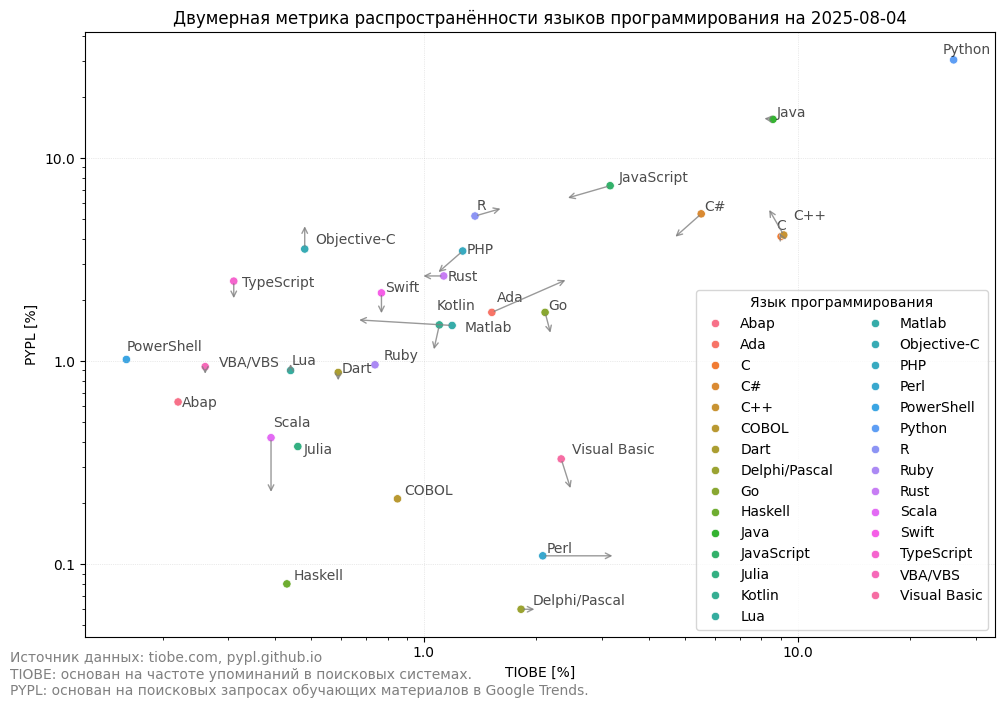

In [11]:
def norm(a, b) -> float:
    return (a**2 + b**2) ** (1 / 2)


fig = plt.figure(figsize=(10, 7))
ax = sns.scatterplot(data=short_rank_all, x="share_tiobe", y="share_pypl", hue="lang")
plt.xscale("log")
plt.yscale("log")
ax.set(
    xlabel="TIOBE [%]",
    ylabel="PYPL [%]",
    title=f"Двумерная метрика распространённости языков программирования на {
        dt.date.today()
    }",
    # xlim=(0, 50),
    # ylim=(0, 50),
)
ax.grid(ls=":", lw=0.5, alpha=0.5)
texts = []
for x in short_rank_all.itertuples():
    texts.append(ax.text(x.share_tiobe, x.share_pypl, x.lang, fontsize=10, alpha=0.7))
    if (x.trend_tiobe is not None) and (x.trend_pypl is not None):
        ax.annotate(
            "",
            xy=(x.trend_tiobe + x.share_tiobe, x.trend_pypl + x.share_pypl),
            xytext=(x.share_tiobe, x.share_pypl),
            arrowprops=dict(arrowstyle="->", lw=1, alpha=0.8, color="grey"),
        )
adjust_text(texts)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc="lower right", ncol=2, title="Язык программирования")
textstr = "\n".join(
    (
        "Источник данных: tiobe.com, pypl.github.io",
        "TIOBE: основан на частоте упоминаний в поисковых системах.",
        "PYPL: основан на поисковых запросах обучающих материалов в Google Trends.",
    )
)
fig.text(0, 0, textstr, color="grey")
# fig.subplots_adjust(bottom=0.2)
fig.tight_layout()
fig.savefig(Path("output.png"), dpi=300)

## Расчёт с учётом оценки производительности

In [12]:
alias_bench = {
    "chapel": "Chapel",
    "clang": "C/C++",
    "csharpaot": "C#",
    "csharpcore": "C#",
    "dartexe": "Dart",
    "dartjit": "Dart",
    "erlang": "Erland",
    "fpascal": "Free Pascal",
    "fsharpcore": "F#",
    "gcc": "C/C++",
    "ghc": "Haskell",
    "gnat": "Ada",
    "go": "Go",
    "gpp": "C/C++",
    "graalvm": "Graal",
    "icx": "C/C++",
    "ifc": "Fortran",
    "ifx": "Fortran",
    "java": "Java",
    "javaxint": "Java",
    "julia": "Julia",
    "lua": "Lua",
    "micropython": "Python",
    "mri": "Ruby",
    "node": "JavaScript",
    "ocaml": "OCaml",
    "openj9": "Java",
    "perl": "Perl",
    "pharo": "Smalltalk",
    "php": "PHP",
    "python3": "Python",
    "racket": "Racket",
    "ruby": "Ruby",
    "rust": "Rust",
    "sbcl": "Lisp",
    "swift": "Swift",
    "toit": "Toit",
    "vw": "",
}

In [13]:
bench_game = pd.read_csv(Path("data/alldata.csv"))
bench_game = bench_game[bench_game["status"] >= 0]
bench_game.drop(columns=["id", "n"], inplace=True)
bench_game

,name,lang,size(B),cpu-time(s),mem(KB),status,make-time(s),elapsed-time(s),threefour(s),onetwo(s),cpu-time-mean(s),cpu-time-variance,cpu-time-sample
0,binarytrees,sbcl,595,9.729,665079808,0,2.51,10.215,0.0,0.0,0.0,0.0,1
1,binarytrees,sbcl,595,9.582,665092096,0,2.51,9.604,0.0,0.0,0.0,0.0,1
2,binarytrees,sbcl,595,9.681,664944640,0,2.51,9.698,0.0,0.0,0.0,0.0,1
3,binarytrees,sbcl,595,9.648,664936448,0,2.51,9.667,0.0,0.0,0.0,0.0,1
4,binarytrees,sbcl,595,9.612,665083904,0,2.51,9.633,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15158,spectralnorm,julia,377,5.823,414752768,0,0.14,2.851,0.0,0.0,0.0,0.0,1
15159,spectralnorm,julia,377,5.846,414855168,0,0.14,2.890,0.0,0.0,0.0,0.0,1
15160,spectralnorm,julia,377,5.849,414855168,0,0.14,2.880,0.0,0.0,0.0,0.0,1
15161,spectralnorm,julia,377,5.853,414863360,0,0.14,2.898,0.0,0.0,0.0,0.0,1


In [14]:
a = bench_game.groupby(["lang", "name"]).min(numeric_only=True).groupby("lang").median()
a["lang_name"] = a.index.map(alias_bench)
a

,size(B),cpu-time(s),mem(KB),status,make-time(s),elapsed-time(s),threefour(s),onetwo(s),cpu-time-mean(s),cpu-time-variance,cpu-time-sample,lang_name
lang,,,,,,,,,,,,
chapel,526.0,0.0670,9951232.0,0.0,20.620,0.8650,0.00,0.0,0.0,0.0,1.0,Chapel
clang,660.0,0.0310,2945024.0,0.0,5.070,0.0750,0.00,0.0,0.0,0.0,1.0,C/C++
csharpaot,668.0,0.0480,6197248.0,0.0,23.770,0.1330,0.00,0.0,0.0,0.0,1.0,C#
csharpcore,668.0,0.1490,33103872.0,0.0,7.510,0.7330,0.00,0.0,0.0,0.0,1.0,C#
dartexe,513.0,0.0850,9474048.0,0.0,4.850,0.1090,0.00,0.0,0.0,0.0,1.0,Dart
dartjit,513.0,1.2690,187912192.0,0.0,1.960,3.3520,0.00,0.0,0.0,0.0,1.0,Dart
erlang,871.0,31.5010,77963264.0,0.0,1.040,15.2210,0.00,0.0,0.0,0.0,1.0,Erland
fpascal,959.0,5.6120,1040384.0,0.0,0.750,3.9120,0.00,0.0,0.0,0.0,1.0,Free Pascal
fsharpcore,705.0,0.2650,42029056.0,0.0,12.135,1.3630,0.00,0.0,0.0,0.0,1.0,F#


In [15]:
a = a.groupby("lang_name").median().sort_values(by="elapsed-time(s)", ascending=True)
a

,size(B),cpu-time(s),mem(KB),status,make-time(s),elapsed-time(s),threefour(s),onetwo(s),cpu-time-mean(s),cpu-time-variance,cpu-time-sample
lang_name,,,,,,,,,,,
Rust,883.5,0.0265,3850240.0,0.0,10.9300,0.04600,0.000,0.0,0.0,0.0,1.0
C/C++,660.0,0.0350,2942976.0,0.0,3.6725,0.06550,0.000,0.0,0.0,0.0,1.0
Haskell,801.5,0.0565,11352064.0,0.0,17.5250,0.23050,0.000,0.0,0.0,0.0,1.0
C#,668.0,0.0985,19650560.0,0.0,15.6400,0.43300,0.000,0.0,0.0,0.0,1.0
Lua,485.0,0.4495,3700736.0,0.0,0.1600,0.69700,0.000,0.0,0.0,0.0,1.0
Chapel,526.0,0.0670,9951232.0,0.0,20.6200,0.86500,0.000,0.0,0.0,0.0,1.0
Swift,678.0,0.0780,13680640.0,0.0,12.5400,0.97300,0.000,0.0,0.0,0.0,1.0
F#,705.0,0.2650,42029056.0,0.0,12.1350,1.36300,0.000,0.0,0.0,0.0,1.0
Dart,513.0,0.6770,98693120.0,0.0,3.4050,1.73050,0.000,0.0,0.0,0.0,1.0


In [16]:
a.loc["C"] = a.loc["C/C++"]
a.loc["C++"] = a.loc["C/C++"]
a.sort_values(by="cpu-time(s)", ascending=True)

,size(B),cpu-time(s),mem(KB),status,make-time(s),elapsed-time(s),threefour(s),onetwo(s),cpu-time-mean(s),cpu-time-variance,cpu-time-sample
lang_name,,,,,,,,,,,
Rust,883.5,0.0265,3850240.0,0.0,10.9300,0.04600,0.000,0.0,0.0,0.0,1.0
C/C++,660.0,0.0350,2942976.0,0.0,3.6725,0.06550,0.000,0.0,0.0,0.0,1.0
C,660.0,0.0350,2942976.0,0.0,3.6725,0.06550,0.000,0.0,0.0,0.0,1.0
C++,660.0,0.0350,2942976.0,0.0,3.6725,0.06550,0.000,0.0,0.0,0.0,1.0
Haskell,801.5,0.0565,11352064.0,0.0,17.5250,0.23050,0.000,0.0,0.0,0.0,1.0
Chapel,526.0,0.0670,9951232.0,0.0,20.6200,0.86500,0.000,0.0,0.0,0.0,1.0
Swift,678.0,0.0780,13680640.0,0.0,12.5400,0.97300,0.000,0.0,0.0,0.0,1.0
C#,668.0,0.0985,19650560.0,0.0,15.6400,0.43300,0.000,0.0,0.0,0.0,1.0
F#,705.0,0.2650,42029056.0,0.0,12.1350,1.36300,0.000,0.0,0.0,0.0,1.0


In [17]:
b = short_rank_all.join(a["elapsed-time(s)"], on="lang")
b["slower"] = b["elapsed-time(s)"] / (b["elapsed-time(s)"].min())
for col in ["share_tiobe", "share_pypl", "trend_tiobe", "trend_pypl"]:
    b[col] = b[col] / b["slower"]
b.dropna(subset=["share_tiobe", "share_pypl"], how="any", inplace=True)
b

,lang,rank_tiobe,share_tiobe,trend_tiobe,rank_pypl,share_pypl,trend_pypl,trend_norm,share_norm,norm_ratio,elapsed-time(s),slower
1,Ada,13.0,0.017114,0.010246,12.0,0.019591,0.009007,1.211652,2.310411,0.524431,4.08550,88.815217
2,C,3.0,6.341679,-0.105344,NaN,2.890496,0.187741,0.306535,9.923751,0.030889,0.06550,1.423913
3,C#,5.0,0.586420,-0.092425,5.0,0.565173,-0.138106,1.564257,7.666342,0.204042,0.43300,9.413043
4,C++,2.0,6.447023,-0.603969,NaN,2.938511,1.076381,1.757466,10.088598,0.174203,0.06550,1.423913
6,Dart,28.0,0.015683,0.000000,20.0,0.023392,-0.002658,0.100000,1.059481,0.094386,1.73050,37.619565
8,Go,8.0,0.025718,0.000975,13.0,0.021208,-0.004875,0.407922,2.734904,0.149154,3.77400,82.043478
9,Haskell,32.0,0.085813,0.000000,28.0,0.015965,0.000000,0.000000,0.437379,0.000000,0.23050,5.010870
10,Java,4.0,0.103807,-0.007009,2.0,0.187795,0.002417,0.613514,17.756117,0.034552,3.80650,82.750000
11,JavaScript,6.0,0.051310,-0.012380,4.0,0.119235,-0.016289,1.256025,7.968996,0.157614,2.82400,61.391304
12,Julia,30.0,0.011419,0.000000,23.0,0.009433,0.000000,0.000000,0.596657,0.000000,1.85300,40.282609


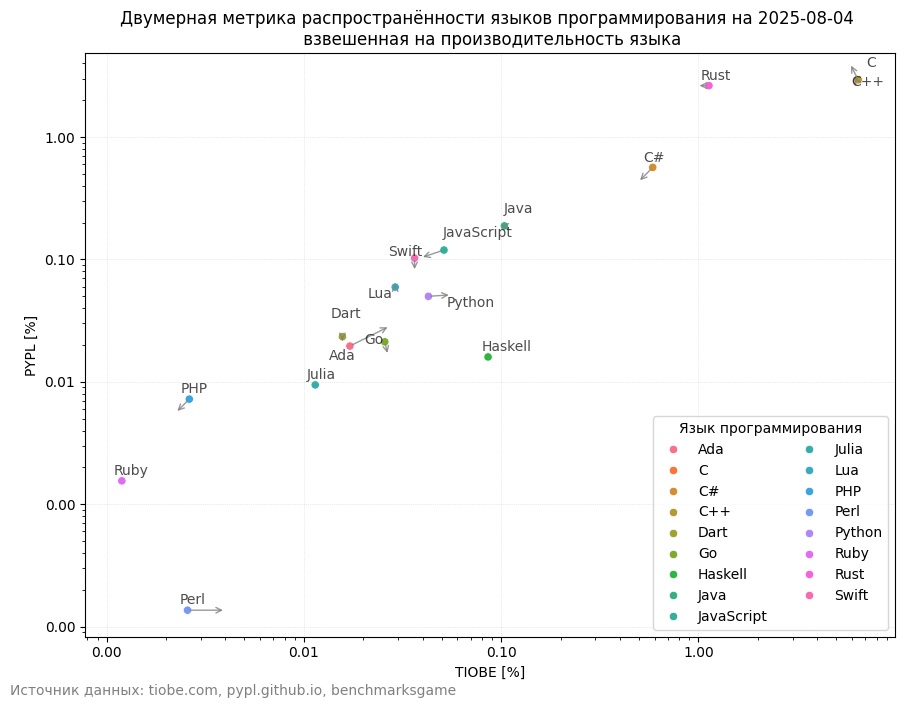

In [18]:
fig = plt.figure(figsize=(9, 7))
ax = sns.scatterplot(data=b, x="share_tiobe", y="share_pypl", hue="lang")
plt.xscale("log")
plt.yscale("log")
ax.set(
    xlabel="TIOBE [%]",
    ylabel="PYPL [%]",
    title=f"Двумерная метрика распространённости языков программирования на {
        dt.date.today()
    } \n взвешенная на производительность языка",
    # xlim=(0, 50),
    # ylim=(0, 50),
)
ax.grid(ls=":", lw=0.5, alpha=0.5)
texts = []
obj = []
xx = []
yy = []
for x in b.itertuples():
    texts.append(
        ax.text(
            x.share_tiobe, x.share_pypl, x.lang, fontsize=10, alpha=0.7, ha="center"
        )
    )
    if (
        (x.trend_tiobe is not None)
        and (x.trend_pypl is not None)
        and x.trend_norm > 0.0
    ):
        xx.append(x.trend_tiobe + x.share_tiobe)
        yy.append(x.trend_pypl + x.share_pypl)
        ax.annotate(
            "",
            xy=(x.trend_tiobe + x.share_tiobe, x.trend_pypl + x.share_pypl),
            xytext=(x.share_tiobe, x.share_pypl),
            arrowprops=dict(arrowstyle="->", lw=1, alpha=0.8, color="grey"),
        )
adjust_text(texts, x=xx, y=yy, ax=ax)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc="lower right", ncol=2, title="Язык программирования")
fig.tight_layout()
fig.text(
    0, 0, f"Источник данных: tiobe.com, pypl.github.io, benchmarksgame", color="grey"
)
fig.savefig(Path("perf_rank.png"), dpi=300)